<a href="https://colab.research.google.com/github/mot1122/NLP_100_knock/blob/main/chap9_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 89 事前学習済み言語モデルからの転移学習
>>
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．


In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-28 15:33:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  11.7MB/s    in 2.4s    

2022-01-28 15:34:01 (11.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [3]:
! head -n 3 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550


In [4]:
!sed -e "s/"\""/'/g" newsCorpora.csv > newsCorpora_re.csv

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df=pd.read_csv("./newsCorpora_re.csv",sep="\t",header=None,names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df=df.loc[df["PUBLISHER"].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),["TITLE","CATEGORY"]]

In [7]:
train,valid_test=train_test_split(df,test_size=0.2,shuffle=True,random_state=123,stratify=df["CATEGORY"])
valid,test=train_test_split(valid_test,test_size=0.5,shuffle=True,random_state=123,stratify=valid_test["CATEGORY"])
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [8]:
print(train.head(3))

                                               TITLE CATEGORY
0  REFILE-UPDATE 1-European car sales up for sixt...        b
1  Amazon Plans to Fight FTC Over Mobile-App Purc...        t
2  Kids Still Get Codeine In Emergency Rooms Desp...        m


In [9]:
print("train data")
print(train["CATEGORY"].value_counts())
print()
print("valid data")
print(valid["CATEGORY"].value_counts())
print()
print("test data")
print(test["CATEGORY"].value_counts())

train data
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64

valid data
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64

test data
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [10]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 10.0 MB/s 
     |████████████████████████████████| 596 kB 35.3 MB/s 
     |████████████████████████████████| 895 kB 31.5 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 6.8 MB 34.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn,optim,cuda
import transformers
from transformers import BertTokenizer,BertModel
import time
from matplotlib import pyplot as plt

In [12]:
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self): 
    return len(self.y)

  def __getitem__(self, index): 
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [13]:
y_train=pd.get_dummies(train,columns=["CATEGORY"])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid=pd.get_dummies(valid,columns=["CATEGORY"])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test=pd.get_dummies(test,columns=["CATEGORY"])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

In [14]:
max_len=10
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

dataset_train=CreateDataset(train["TITLE"],y_train,tokenizer,max_len)
dataset_valid=CreateDataset(valid["TITLE"],y_valid,tokenizer,max_len)
dataset_test=CreateDataset(test["TITLE"],y_test,tokenizer,max_len)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
for var in dataset_train[0]:
  print(f"{var}: {dataset_train[0][var]}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,   102])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
class BertClass(nn.Module):
  def __init__(self,drop_rate,output_size):
    super().__init__()
    self.bert=BertModel.from_pretrained("bert-base-uncased",return_dict=False)
    self.drop=nn.Dropout(drop_rate)
    self.fc=nn.Linear(768,output_size)
  def forward(self,ids,mask):
    _,out=self.bert(ids,attention_mask=mask)
    out=self.fc(self.drop(out))
    return out

In [17]:
def culculate_loss_and_accuracy(model,criterion,dataloader,device):
  model.to(device)
  total,correct,loss=0,0,0.0
  model.eval()
  with torch.no_grad():
    for data in dataloader:
      ids=data["ids"].to(device)
      mask=data["mask"].to(device)
      labels=data["labels"].to(device)
      outputs=model.forward(ids,mask)
      loss+=criterion(outputs,labels)
      pred=torch.argmax(outputs,dim=-1).cpu().numpy()
      labels=torch.argmax(labels,dim=-1).cpu().numpy()
      total+=len(labels)
      correct+=(pred==labels).sum().item()
  return loss/len(dataloader),correct/total

In [18]:
def train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,device=None):
  model.to(device)
  dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
  dataloader_valid=DataLoader(dataset_valid,batch_size=len(dataset_valid),shuffle=False)
  log_train,log_valid=[],[]
  for epoch in range(1,epochs+1):
    s_time=time.time()
    model.train()
    for data in dataloader_train:
      ids=data["ids"].to(device)
      mask=data["mask"].to(device)
      labels=data["labels"].to(device)
      optimizer.zero_grad()
      
      outputs=model(ids,mask)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      
    train_loss,train_acc=culculate_loss_and_accuracy(model,criterion,dataloader_train,device)
    valid_loss,valid_acc=culculate_loss_and_accuracy(model,criterion,dataloader_valid,device)
    log_train.append([train_loss,train_acc])
    log_valid.append([valid_loss,valid_acc])
    torch.save({"epoch":epoch,"model_state_dict":model.state_dict(),"optimizer_state_dict":optimizer.state_dict()},f"checkpoint{epoch}.pt")
    e_time=time.time()
    print(f"epoch:{epoch},train_loss:{train_loss:.3f},train_acc:{train_acc:.3f},valid_loss:{valid_loss:.3f},valid_acc:{valid_acc:.3f},time:{e_time-s_time:.1f}")
  return {"train":log_train,"valid":log_valid}

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will

epoch:1,train_loss:0.377,train_acc:0.768,valid_loss:0.377,valid_acc:0.776,time:67.6
epoch:2,train_loss:0.188,train_acc:0.896,valid_loss:0.205,valid_acc:0.872,time:68.1
epoch:3,train_loss:0.124,train_acc:0.933,valid_loss:0.163,valid_acc:0.894,time:67.5


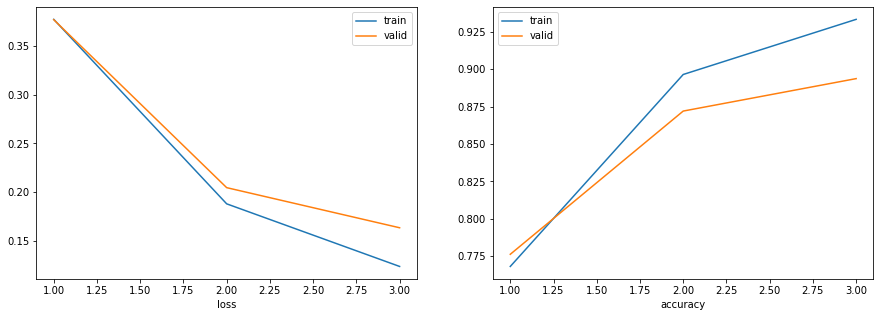

In [19]:
drop_rate = 0.4
output_size = 4
batch_size = 256
epochs = 3
lr = 2e-5
device="cuda"

model=BertClass(drop_rate,output_size)
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.AdamW(params=model.parameters(),lr=lr)
log=train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,device=device)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range(1,epochs+1),np.array(log["train"]).T[0],label="train")
ax[0].plot(range(1,epochs+1),np.array(log["valid"]).T[0],label="valid")
ax[0].set_xlabel("epochs")
ax[0].set_xlabel("loss")
ax[0].legend()
ax[1].plot(range(1,epochs+1),np.array(log["train"]).T[1],label="train")
ax[1].plot(range(1,epochs+1),np.array(log["valid"]).T[1],label="valid")
ax[1].set_xlabel("epochs")
ax[1].set_xlabel("accuracy")
ax[1].legend()
plt.show()

In [20]:
def culculate_accuracy(model,dataset,device):
  model.to(device)
  dataloader=DataLoader(dataset,batch_size=len(dataset),shuffle=False)
  total,correct=0,0
  model.eval()
  with torch.no_grad():
    for data in dataloader:
      ids=data["ids"].to(device)
      mask=data["mask"].to(device)
      labels=data["labels"].to(device)
      outputs=model.forward(ids,mask)
      pred=torch.argmax(outputs,dim=-1).cpu().numpy()
      labels=torch.argmax(labels,dim=-1).cpu().numpy()
      total+=len(labels)
      correct+=(pred==labels).sum().item()
  return correct/total

In [22]:
print(f"train accuracy:{culculate_accuracy(model,dataset_train,device):.3f}")
print(f"valid accuracy:{culculate_accuracy(model,dataset_valid,device):.3f}")
print(f"test accuracy:{culculate_accuracy(model,dataset_test,device):.3f}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


train accuracy:0.933
valid accuracy:0.894
test accuracy:0.893
